<a href="https://colab.research.google.com/github/hamednasr/CIFAR-10-classification/blob/main/PyTorch_CIFAR_10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR 10 classification using PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
trans = T.Compose([T.ToTensor()])

In [3]:
# device= 'cpu'
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
device

device(type='cuda', index=0)

In [4]:
train = torchvision.datasets.CIFAR10(root = 'cifar10',download=True,transform=trans)
train

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10/cifar-10-python.tar.gz to cifar10


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
test = torchvision.datasets.CIFAR10(root = 'cifar10',train=False,download=True,transform=trans)
test

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
test.data[11,:].shape

(32, 32, 3)

In [7]:
trans(test.data[11,:]).shape

torch.Size([3, 32, 32])

In [8]:
test.transform(test.data[11,:]).shape

torch.Size([3, 32, 32])

In [9]:
train.data.shape

(50000, 32, 32, 3)

In [10]:
test.data.shape

(10000, 32, 32, 3)

In [11]:
# trainlabel = train.targets

In [12]:
# testlabel = test.targets

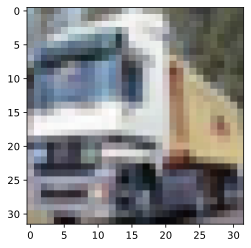

In [13]:
plt.imshow(train.data[1])

# data preparation for pytorch

In [14]:
train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [15]:
# traindata = traindata.reshape(traindata.shape[0],3,32,32)
# testdata = testdata.reshape(testdata.shape[0],3,32,32)

In [16]:
# traindataT = torch.tensor(traindata).float() 
# testdataT = torch.tensor(testdata).float() 

In [17]:
# trainlabelT = torch.tensor(trainlabel).long()
# testlabelT = torch.tensor(testlabel).long()

In [18]:
# traindataT.shape

In [19]:
# testdataT.shape

In [20]:
# trainlabelT

In [21]:
# traindata,testdata,trainlabel,testlabel=train_test_split(imagesT,labelsT,test_size=.1)

In [22]:
# trainset = TensorDataset(traindataT,trainlabelT)

In [23]:
# testset = TensorDataset(testdataT,testlabelT)

In [24]:
batchsize=128
trainloader = DataLoader(train,batch_size=batchsize,shuffle=True,drop_last=True)

In [25]:
testloader = DataLoader(test,batch_size=10000)

## building model:

In [88]:
def CreateModel():
  
  class CNNmodel(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3,50,kernel_size=3,stride=1,padding=1) #first conv layer
      # (32+2*1-3)/1+1=32   max pool:32/2 = 16
      self.batchnorm1 = nn.BatchNorm2d(50)
      
      self.conv2 = nn.Conv2d(50,100,kernel_size=3,padding=1) #second conv layer
      #(16+2*1-3)/1+1 = 16  max pool: 16/2 = 8
      self.batchnorm2 = nn.BatchNorm2d(100)

      self.conv3 = nn.Conv2d(100,200,kernel_size=3) #third conv layer
      # # #(8+2*0-3)/1+1 = 6  max pool: 6/2 = 3
      self.batchnorm3 = nn.BatchNorm2d(200)

      self.fc1 = nn.Linear(3*3*200,400)

      self.fc2 = nn.Linear(400,100)

      self.out = nn.Linear(100,10)

    
    def forward(self,x):

      x = F.max_pool2d(self.conv1(x),2)
      x= F.leaky_relu(self.batchnorm1(x))
      x = F.dropout(x, p=0.2, training = self.training) 

      x = F.max_pool2d(self.conv2(x),2)
      x= F.leaky_relu(self.batchnorm2(x))
      x = F.dropout(x, p=0.2, training = self.training) 

      x = F.max_pool2d(self.conv3(x),2)
      x= F.leaky_relu(self.batchnorm3(x))
      x = F.dropout(x, p=0.2, training = self.training) 

      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))

      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x, p=0.5, training = self.training)

      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x, p=0.5, training = self.training)
      
      x = self.out(x)      
      
      return x

  CNN = CNNmodel()

  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(params=CNN.parameters(), lr = 0.001)

  return CNN, lossfun, optimizer

## Sanity checking of the model:

In [89]:
X = torch.randn(5,3,32,32)
CNN, lossfun, optimizer = CreateModel()
yhat = CNN(X)
print(yhat.shape)
print(torch.argmax(yhat,1))

torch.Size([5, 10])
tensor([0, 2, 0, 5, 0])


## Train the model:

In [93]:
epochs = 20

def TrainModel():

  CNN, lossfun, optimizer = CreateModel()
  CNN.to(device)

  trainacc = []
  testacc = []
  trainloss = []
  testloss = []

  for i in range(epochs):
    
    CNN.train()

    batchloss = []
    batchacc = []

    for X, y in trainloader:

      X = X.to(device)
      y = y.to(device)
      
      yhat = CNN(X)

      loss = lossfun(yhat,y)
      batchloss.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step() 

      batchacc.append(100*torch.mean(((torch.argmax(yhat,1)==y).float())).item())

    trainloss.append(np.mean(batchloss))
    trainacc.append(np.mean(batchacc))

    CNN.eval()
    X,y = next(iter(testloader))
    X = X.to(device)
    y = y.to(device)
    yhat = CNN(X)
    testloss.append(lossfun(yhat,y).item())
    testacc.append( 100*torch.mean(((torch.argmax(yhat,1)==y).float())).item() )
    print(f'{i+1} of {epochs} epochs done.')

  return trainacc, testacc, trainloss, testloss

In [94]:
trainacc, testacc, trainloss, testloss = TrainModel()

1 of 20 epochs done.
2 of 20 epochs done.
3 of 20 epochs done.
4 of 20 epochs done.
5 of 20 epochs done.
6 of 20 epochs done.
7 of 20 epochs done.
8 of 20 epochs done.
9 of 20 epochs done.
10 of 20 epochs done.
11 of 20 epochs done.
12 of 20 epochs done.
13 of 20 epochs done.
14 of 20 epochs done.
15 of 20 epochs done.
16 of 20 epochs done.
17 of 20 epochs done.
18 of 20 epochs done.
19 of 20 epochs done.
20 of 20 epochs done.


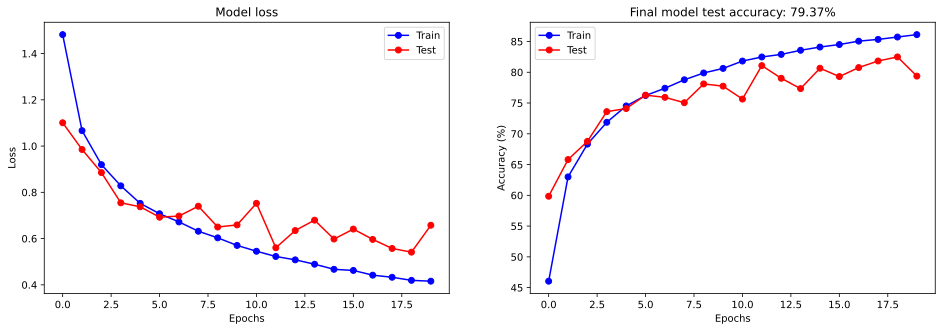

In [95]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainloss,'bo-',label='Train')
ax[0].plot(testloss,'ro-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainacc,'bo-',label='Train')
ax[1].plot(testacc,'ro-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testacc[-1]:.2f}%')
ax[1].legend()

plt.show()